In [1]:
import sys
sys.path.append("../")

In [2]:
from compert.train import train_compert
from compert.data import load_dataset_splits
from compert.plotting import CompertVisuals, ComPertHistory
from compert.api import ComPertAPI, get_reference_from_combo
import pandas as pd
import compert.plotting as pl


In [3]:
from os import listdir
from os.path import isfile, join
from os import walk

mypath = '../pretrained_models/'
_, folders, _ = next(walk(mypath))
for fold in folders:
    for f in listdir(join(mypath, fold)):
        if 'pachter_new' in f:
            print(join(mypath, fold, f))

../pretrained_models/pachter/sweep_pachter_new_logsigm_model_seed=151_epoch=480.pt


# Pachter

In [4]:
import torch
from compert.train import prepare_compert

model_name = '../pretrained_models/pachter/sweep_pachter_new_logsigm_model_seed=151_epoch=480.pt'

plots_prefix = f"../results/plots/{model_name.split('/')[-2]}_{model_name.split('/')[-1]}"

In [5]:
state, args, history = torch.load(model_name, map_location=torch.device('cpu'))
args['dataset_path'] = '../datasets/pachter_new.h5ad'
    
# load the dataset and model pre-trained weights
autoencoder, datasets = prepare_compert(args, state_dict=state)


Computation time: 13 min
Saved file to: ../results/plots/pachter_sweep_pachter_new_logsigm_model_seed=151_epoch=480.pt_history_losses.png
Saved file to: ../results/plots/pachter_sweep_pachter_new_logsigm_model_seed=151_epoch=480.pt_history_metrics.png


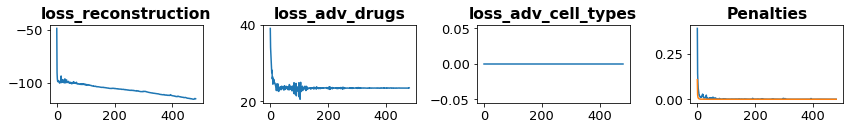

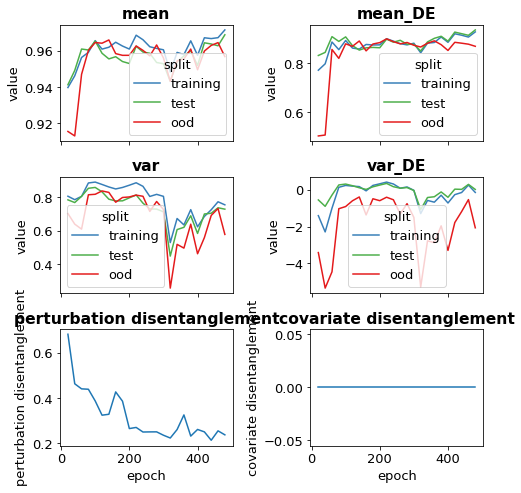

In [6]:
pretty_history = ComPertHistory(history, fileprefix=plots_prefix)
pretty_history.print_time()
pretty_history.plot_losses()
pretty_history.plot_metrics(epoch_min=0)

In [7]:
# datasets, full_dataset = load_dataset_splits(
#     dataset_path=args["dataset_path"],
#     perturbation_key=args["perturbation_key"],
#     dose_key=args["dose_key"],
#     cell_type_key=args["cell_type_key"],
#     split_key=args['split_key'],
#     return_dataset=True) 

In [8]:
compert_api = ComPertAPI(datasets, autoencoder)

In [12]:
compert_api.num_measured_points['training']

{'unknown_BMP+EGF+RA_0.04+0.04+0.2': 119,
 'unknown_BMP+EGF+RA_0.04+0.2+0.2': 499,
 'unknown_BMP+EGF+RA_0.04+0.2+1.0': 3187,
 'unknown_BMP+EGF+RA_0.04+1.0+0.2': 293,
 'unknown_BMP+EGF+RA_0.04+1.0+1.0': 995,
 'unknown_BMP+EGF+RA_0.2+0.04+0.2': 326,
 'unknown_BMP+EGF+RA_0.2+0.04+1.0': 290,
 'unknown_BMP+EGF+ScripDec_0.04+0.04+0.2': 85,
 'unknown_BMP+EGF+ScripDec_0.04+0.04+1.0': 181,
 'unknown_BMP+EGF+ScripDec_0.04+0.2+0.2': 149,
 'unknown_BMP+EGF+ScripDec_0.04+0.2+1.0': 181,
 'unknown_BMP+EGF+ScripDec_0.04+1.0+1.0': 99,
 'unknown_BMP+EGF+ScripDec_0.2+0.04+0.2': 132,
 'unknown_BMP+EGF+ScripDec_0.2+0.04+1.0': 151,
 'unknown_BMP+EGF+ScripDec_1.0+0.04+0.2': 86,
 'unknown_BMP+EGF_0.04+0.04': 156,
 'unknown_BMP+EGF_0.04+0.2': 601,
 'unknown_BMP+EGF_0.04+1.0': 1251,
 'unknown_BMP+EGF_1.0+0.04': 103,
 'unknown_BMP+RA_0.2+1.0': 120,
 'unknown_EGF+RA_0.04+1.0': 383,
 'unknown_EGF+RA_0.2+0.2': 420,
 'unknown_EGF+RA_0.2+1.0': 3090,
 'unknown_EGF+RA_1.0+0.2': 184,
 'unknown_EGF+RA_1.0+1.0': 1190,
 'u

In [13]:
import pprint

split = 'ood'
for pert in compert_api.measured_points[split].keys():
    pprint.pprint(compert_api.measured_points[split][pert])

{'BMP+EGF': ['1.0+1.0'],
 'BMP+EGF+RA': ['0.2+0.2+0.2', '0.2+0.2+1.0', '0.2+1.0+0.2', '0.2+1.0+1.0'],
 'BMP+EGF+ScripDec': ['0.2+0.2+0.2',
                      '0.2+0.2+1.0',
                      '0.2+1.0+0.2',
                      '0.2+1.0+1.0',
                      '1.0+0.2+0.2']}


In [14]:
perts_anndata = compert_api.get_drug_embeddings()

In [15]:
compert_plots = CompertVisuals(compert_api, fileprefix=f"../paper_figures/figure2/{model_name.split('/')[-2]}")

Saved file to: ../paper_figures/figure2/pachter_emebdding.png
Saved file to: ../paper_figures/figure2/pachter_emebdding_similarity.png


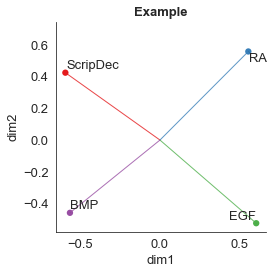

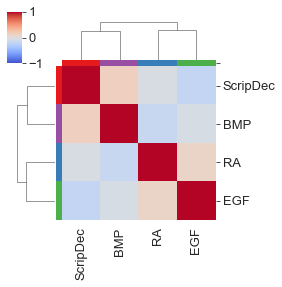

In [16]:
compert_plots.plot_latent_embeddings(compert_api.emb_perts, kind='perturbations', show_text=True)

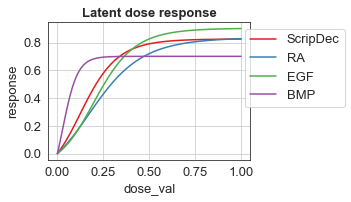

In [17]:
latent_response = compert_api.latent_dose_response()
compert_plots.plot_contvar_response(
    latent_response, 
    postfix='latent',
    var_name=compert_api.perturbation_key,
    figsize=(6, 3),
    bbox=(1.5, 1.),
    title_name='Latent dose response')

In [18]:
import numpy as np
drugs_to_mix_list = []
doses_to_mix_list = []
for comb in np.unique(datasets['training'].pert_categories):
    _, drug, dose = comb.split('_')
    drugs_to_mix_list.append(drug)
    doses_to_mix_list.append(dose)

In [19]:
adata_comb = compert_api.mix_drugs(drugs_to_mix_list, doses_list=doses_to_mix_list, return_anndata=True)

In [20]:
adata_comb

AnnData object with n_obs × n_vars = 28 × 128
    obs: 'condition', 'dose_val'

In [21]:
conds = list(np.unique(adata_comb.obs['condition'].values))

In [22]:
palette = {'BMP+EGF': '#1f77b4',
 'BMP+EGF+RA': '#ff7f0e',
 'BMP+EGF+ScripDec': '#279e68',
 'BMP+RA': '#d62728',
 'EGF': '#aa40fc',
 'EGF+RA': '#8c564b'}

Saved file to: ../paper_figures/figure2/pachter_emebdding.png
Saved file to: ../paper_figures/figure2/pachter_emebdding_similarity.png


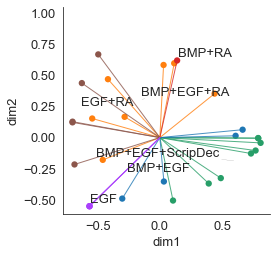

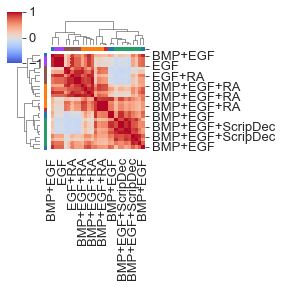

In [23]:
compert_plots.plot_latent_embeddings(adata_comb.X, 
                                     labels=adata_comb.obs['condition'].values, 
                                     kind='combos',
                                     palette=palette,
                                     titlename='',
                                     show_text=True)

In [24]:
# emd_unst = adata_comb.X.copy()
# for i in range(len(adata_comb.X)):
#     emd_unst[i] = compert_api.emb_covars[0].copy() + adata_comb.X[i]

# compert_plots.plot_latent_embeddings(emd_unst, 
#                                      labels=adata_comb.obs['condition'].values, 
#                                      kind='combos',
#                                      palette=palette,
#                                      titlename='',
#                                      show_text=True)

EGF+RA 0.04+1.0 383
EGF+RA 0.2+0.2 420
EGF+RA 0.2+1.0 3090
EGF+RA 1.0+0.2 184
EGF+RA 1.0+1.0 1190
Saved file to: ../paper_figures/figure2/pachter_reconst_EGF_RAresponse2D.png


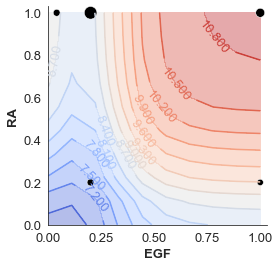

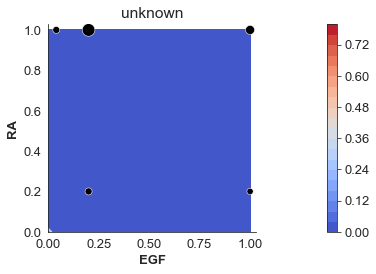

In [25]:
perturbations_pair = ['EGF', 'RA']
df_ref_pair = get_reference_from_combo(perturbations_pair, datasets)

reconstructed_response2D = compert_api.get_response2D(datasets,
                                                      perturbations_pair,
                                                      'unknown', 
                                                      contvar_min=0.0,
                                                      contvar_max=1.0)

compert_plots.plot_contvar_response2D(reconstructed_response2D, 
    title_name='', 
    df_ref=df_ref_pair,
    postfix=f'reconst_EGF_RA', logdose=False)

df_pred = pl.plot_uncertainty_comb_dose(
    compert_api=compert_api,
    cov='unknown',
    pert='EGF+RA',
    N=51,
#     measured_points=compert_api.measured_points['all'],
    cond_key='treatment',
    metric='cosine',
#     vmax=0.8,
    df_ref=df_ref_pair,
    filename=f'{compert_plots.fileprefix}_uncertainty_EGF_RA.png',
)

In [47]:
dose_BMP = 0.2
perturbations_pair = ['EGF', 'RA']

df_ref_pair = get_reference_from_combo(perturbations_pair + ['BMP'], datasets)
df_ref_pair = df_ref_pair[df_ref_pair['BMP'] == dose_BMP]

BMP+EGF+RA 0.04+0.04+0.2 119
BMP+EGF+RA 0.04+0.2+0.2 499
BMP+EGF+RA 0.04+0.2+1.0 3187
BMP+EGF+RA 0.04+1.0+0.2 293
BMP+EGF+RA 0.04+1.0+1.0 995
BMP+EGF+RA 0.2+0.04+0.2 326
BMP+EGF+RA 0.2+0.04+1.0 290
BMP+EGF+RA 0.2+0.2+0.2 206
BMP+EGF+RA 0.2+0.2+1.0 132
BMP+EGF+RA 0.2+1.0+0.2 216
BMP+EGF+RA 0.2+1.0+1.0 147


Saved file to: ../paper_figures/figure2/pachter_reconst_BMP0.2_EGF_RAresponse2D.png


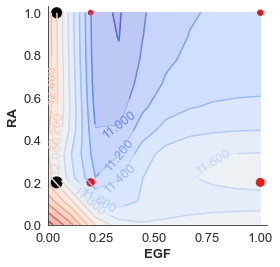

In [27]:
reconstructed_response2D = compert_api.get_response2D(datasets,
                                                      perturbations_pair,
                                                      'unknown',
                                                      fixed_drugs='+BMP',
                                                      fixed_doses='+0.2',
                                                      contvar_min=0.0,
                                                      contvar_max=1.0)

compert_plots.plot_contvar_response2D(reconstructed_response2D, 
    title_name='', 
    df_ref=df_ref_pair,
    postfix=f'reconst_BMP{dose_BMP}_EGF_RA', logdose=False)

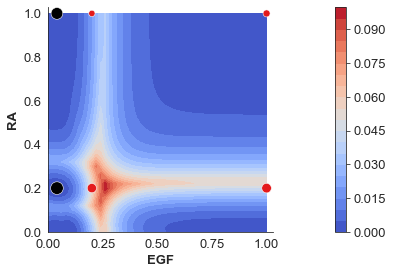

In [64]:
compert_api.compute_comb_emb(thrh=30)

df_pred = pl.plot_uncertainty_comb_dose(
    compert_api=compert_api,
    cov='unknown',
    pert='EGF+RA',
    N=51,
    fixed_drugs='+BMP',
    fixed_doses='+0.2',
    cond_key='treatment',
    metric='cosine',
    title=False,
#     vmax=0.8,
    df_ref=df_ref_pair,
    filename=f'{compert_plots.fileprefix}_uncertainty_BMP{dose_BMP}_EGF_RA.png',
)

In [29]:
# df_pred['dose_val'].values
df_ref_pair

,num_cells,EGF,RA,BMP,split
5,326,0.04,0.2,0.2,training
6,290,0.04,1.0,0.2,training
0,206,0.20,0.2,0.2,ood
1,132,0.20,1.0,0.2,ood
2,216,1.00,0.2,0.2,ood
3,147,1.00,1.0,0.2,ood


In [31]:
compert_api.compute_uncertainty(
                cov='unknown', 
                pert='BMP+EGF+RA',
                dose='0.2+0.04+0.2'
            )

(0.0,
 4.4604033e-07,
 'unknown_BMP+EGF+RA_0.2+0.04+0.2',
 'unknown_BMP+EGF+RA_0.2+0.04+0.2')

In [32]:
compert_api.compute_comb_emb(thrh=30)


BMP+EGF 0.04+0.04 156
BMP+EGF 0.04+0.2 601
BMP+EGF 0.04+1.0 1251
BMP+EGF 1.0+0.04 103
BMP+EGF 1.0+1.0 113
Saved file to: ../paper_figures/figure2/pachter_reconst_BMP_EGFresponse2D.png


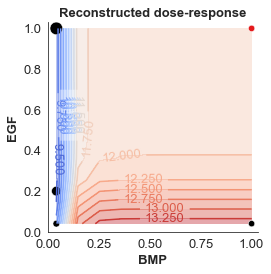

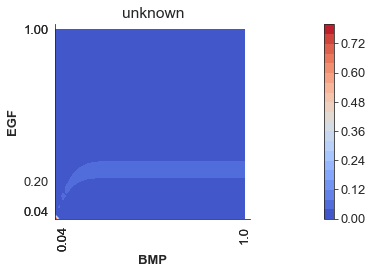

In [33]:
perturbations_pair = ['BMP', 'EGF']
df_ref_pair = get_reference_from_combo(perturbations_pair, datasets)

reconstructed_response2D = compert_api.get_response2D(datasets, perturbations_pair, 'unknown')        
compert_plots.plot_contvar_response2D(reconstructed_response2D, 
    title_name='Reconstructed dose-response',
    df_ref=df_ref_pair,
    postfix=f'reconst_BMP_EGF', logdose=False)

df_pred = pl.plot_uncertainty_comb_dose(
    compert_api=compert_api,
    cov='unknown',
    pert='BMP+EGF',
    N=51,
    measured_points=compert_api.measured_points['all'],
    cond_key='treatment',
    metric='cosine',
    vmax=0.8,
    filename=f'{compert_plots.fileprefix}_uncertainty_BMP_EGF.png',
)

# Evaluation scores

In [53]:
genes_control = datasets['training_control'].genes
df_train = compert_api.evaluate_r2(datasets['training_treated'], genes_control)
df_train['benchmark'] = 'CPA'
df_train['split'] = 'train'

In [54]:
genes_control = datasets['test_control'].genes
df_test = compert_api.evaluate_r2(datasets['test_treated'], genes_control)
df_test['benchmark'] = 'CPA'
df_test['split'] = 'test'

In [55]:
genes_control = datasets['test_control'].genes
df_ood = compert_api.evaluate_r2(datasets['ood'], genes_control)
df_ood['benchmark'] = 'CPA'
df_ood['split'] = 'ood'

In [56]:
df_score = pd.concat([df_test, df_ood])
df_score.round(2).sort_values(by=['condition', 'R2_mean', 'R2_mean_DE'], ascending=False)

,cell_type,condition,dose_val,R2_mean,R2_mean_DE,R2_var,R2_var_DE,num_cells,benchmark,split
22,unknown,EGF+RA,0.2+1.0,0.98,0.95,0.84,0.86,553,CPA,test
24,unknown,EGF+RA,1.0+1.0,0.97,0.94,0.67,0.11,199,CPA,test
21,unknown,EGF+RA,0.2+0.2,0.96,0.98,0.89,0.80,87,CPA,test
20,unknown,EGF+RA,0.04+1.0,0.96,0.90,0.60,-0.11,54,CPA,test
23,unknown,EGF+RA,1.0+0.2,0.95,0.91,0.75,0.36,30,CPA,test
25,unknown,EGF,0.2,0.98,0.96,0.86,0.62,90,CPA,test
26,unknown,EGF,1.0,0.94,0.71,0.60,-0.30,73,CPA,test
19,unknown,BMP+RA,0.2+1.0,0.91,0.84,0.60,-0.15,22,CPA,test
5,unknown,BMP+EGF+ScripDec,0.2+0.2+1.0,0.97,0.97,0.82,0.68,166,CPA,ood
8,unknown,BMP+EGF+ScripDec,0.04+0.04+1.0,0.97,0.96,0.61,-0.71,28,CPA,test


In [57]:
cols_print = ['condition', 'dose_val','R2_mean', 'R2_mean_DE', 'R2_var', 'split', 'num_cells']
df_score = df_score.round(2).sort_values(by=['condition', 'R2_mean', 'R2_mean_DE', 'R2_var'], ascending=False)
df_latex = df_score[cols_print].copy()
df_latex = df_latex.replace('ood', 'textbf{ood}')
print(df_latex.to_latex(index=False, bold_rows=True))
# df_latex

\begin{tabular}{llrrrlr}
\toprule
       condition &      dose\_val &  R2\_mean &  R2\_mean\_DE &  R2\_var &       split &  num\_cells \\
\midrule
          EGF+RA &       0.2+1.0 &     0.98 &        0.95 &    0.84 &        test &        553 \\
          EGF+RA &       1.0+1.0 &     0.97 &        0.94 &    0.67 &        test &        199 \\
          EGF+RA &       0.2+0.2 &     0.96 &        0.98 &    0.89 &        test &         87 \\
          EGF+RA &      0.04+1.0 &     0.96 &        0.90 &    0.60 &        test &         54 \\
          EGF+RA &       1.0+0.2 &     0.95 &        0.91 &    0.75 &        test &         30 \\
             EGF &           0.2 &     0.98 &        0.96 &    0.86 &        test &         90 \\
             EGF &           1.0 &     0.94 &        0.71 &    0.60 &        test &         73 \\
          BMP+RA &       0.2+1.0 &     0.91 &        0.84 &    0.60 &        test &         22 \\
BMP+EGF+ScripDec &   0.2+0.2+1.0 &     0.97 &        0.97 &    0.82 &

# Uncertainty Scores

In [71]:
import pandas as pd
import numpy as np
uncertainty = pd.DataFrame(columns=[compert_api.covars_key, 
                                        compert_api.perturbation_key, 
                                        compert_api.dose_key, 'cosine', 'euclidean', 'split'])

i = 0
for split in ['ood']:
    for pert in compert_api.seen_covars_perts[split]:
        cov, drug, dose = pert.split('_')
        uncert_cos, uncert_eucl, closest_cond_cos, _ = compert_api.compute_uncertainty(cov, drug, dose)
        print(pert, closest_cond_cos)
        uncertainty.loc[i] = [cov, drug, dose, uncert_cos, uncert_eucl, split]
        i+= 1


unknown_BMP+EGF+RA_0.2+0.2+0.2 unknown_BMP+EGF+RA_0.2+0.04+0.2
unknown_BMP+EGF+RA_0.2+0.2+1.0 unknown_BMP+EGF+RA_0.04+0.04+0.2
unknown_BMP+EGF+RA_0.2+1.0+0.2 unknown_BMP+EGF_0.04+0.2
unknown_BMP+EGF+RA_0.2+1.0+1.0 unknown_BMP+EGF+RA_0.04+0.2+0.2
unknown_BMP+EGF+ScripDec_0.2+0.2+0.2 unknown_BMP+EGF+ScripDec_1.0+0.04+0.2
unknown_BMP+EGF+ScripDec_0.2+0.2+1.0 unknown_BMP+EGF+ScripDec_0.2+0.04+1.0
unknown_BMP+EGF+ScripDec_0.2+1.0+0.2 unknown_BMP+EGF_0.04+0.2
unknown_BMP+EGF+ScripDec_0.2+1.0+1.0 unknown_BMP+EGF+ScripDec_0.04+0.2+0.2
unknown_BMP+EGF+ScripDec_1.0+0.2+0.2 unknown_BMP+EGF+ScripDec_1.0+0.04+0.2
unknown_BMP+EGF_1.0+1.0 unknown_BMP+EGF_0.04+0.2


In [66]:
check_ucertainty = uncertainty.merge(df_ood,
                                how="left",
                                on=[compert_api.covars_key,
                                     compert_api.perturbation_key,
                                     compert_api.dose_key])

In [67]:
check_ucertainty

,cell_type,condition,dose_val,cosine,euclidean,split_x,R2_mean,R2_mean_DE,R2_var,R2_var_DE,num_cells,benchmark,split_y
0,unknown,BMP+EGF+RA,0.2+0.2+0.2,0.052529,3.372787,ood,0.966717,0.883962,0.516435,-2.881752,206,CPA,ood
1,unknown,BMP+EGF+RA,0.2+0.2+1.0,0.018973,3.372787,ood,0.948221,0.770416,0.586652,-1.272039,132,CPA,ood
2,unknown,BMP+EGF+RA,0.2+1.0+0.2,0.044195,6.074826,ood,0.956653,0.887556,0.659440,-1.838414,216,CPA,ood
3,unknown,BMP+EGF+RA,0.2+1.0+1.0,0.001768,6.074827,ood,0.957948,0.868135,0.664890,-1.109495,147,CPA,ood
4,unknown,BMP+EGF+ScripDec,0.2+0.2+0.2,0.044614,3.372787,ood,0.973518,0.923480,0.647072,-3.727885,304,CPA,ood
5,unknown,BMP+EGF+ScripDec,0.2+0.2+1.0,0.032911,3.372787,ood,0.967462,0.970915,0.819543,0.680540,166,CPA,ood
6,unknown,BMP+EGF+ScripDec,0.2+1.0+0.2,0.059781,6.393229,ood,0.951577,0.830515,0.584294,-1.729467,105,CPA,ood
7,unknown,BMP+EGF+ScripDec,0.2+1.0+1.0,0.017113,6.074827,ood,0.948017,0.888535,0.511905,-0.998174,112,CPA,ood
8,unknown,BMP+EGF+ScripDec,1.0+0.2+0.2,0.042941,3.368411,ood,0.961530,0.912851,0.743211,-0.073465,113,CPA,ood
9,unknown,BMP+EGF,1.0+1.0,0.003113,6.322929,ood,0.937076,0.754750,0.057264,-7.691173,113,CPA,ood


In [68]:
check_ucertainty['dose_val'][1]

'0.2+0.2+1.0'

In [74]:
text_dict = {}
for i, dose in enumerate(check_ucertainty['dose_val']):    
    if check_ucertainty['condition'][i] == 'BMP+EGF+RA': 
        label2 = f"{dose.split('+')[0]}BMP,{dose.split('+')[1]}EGF,{dose.split('+')[2]}RA"
        label = i+1
        print(f"{label}: {label2}")
        text_dict[label] = [check_ucertainty['R2_mean_DE'][i], check_ucertainty['cosine'][i]]

1: 0.2BMP,0.2EGF,0.2RA
2: 0.2BMP,0.2EGF,1.0RA
3: 0.2BMP,1.0EGF,0.2RA
4: 0.2BMP,1.0EGF,1.0RA


Saved file to: ../paper_figures/figure2/pachter_scattercosine.png
Saved file to: ../paper_figures/figure2/pachter_scattereuclidean.png


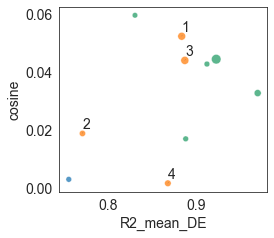

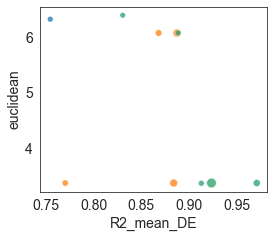

In [75]:
compert_plots.plot_scatter(check_ucertainty, 
         'R2_mean_DE', 
         'cosine',
         hue='condition',
         figsize=(4,3.5),
         style='split_x',
         palette=palette,
         postfix='cosine',
         title='',
         text_dict=text_dict,
         size='num_cells')

compert_plots.plot_scatter(check_ucertainty, 
         'R2_mean_DE', 
         'euclidean',
         hue='condition',
         figsize=(4,3.5),
         style='split_x',
         palette=palette,
         postfix='euclidean',
         title='',
         size='num_cells')

In [77]:
check_ucertainty['cosine'].max().round(2)

0.06

# Comparison with umap

In [39]:
# import scanpy as sc
# adata = sc.read("./datasets/pachter_new.h5ad")

# sc.pp.neighbors(adata, n_neighbors=30, n_pcs=40)


# sc.tl.umap(adata)

# sc.settings.set_figure_params(dpi=80, facecolor='white')
# sc.logging.print_header()
# sc.pl.umap(adata, color=['split', 'condition'], save='.pdf')
# palette = dict(zip(conds, adata.uns['condition_colors']))

# sc.pl.umap(adata, color=['condition'], save='.pdf')

In [40]:
# uncert_general = pd.DataFrame(columns=[compert_api.covars_key, 
#                                             compert_api.perturbation_key, 
#                                             compert_api.dose_key, 'split', 'mean', 'r2'])

# i = 0
# covar = 'unknown'
# doses = np.linspace(0, 1, 10)
# for trial in range(5):
#     for pert in compert_api.unique_perts:
#         for dose in doses:
#             uncert_general.loc[i] = [covar, pert, dose, 'random'] + list(compert_api.get_cycle_uncertainty(pert, covar, dose, datasets["test_control"]))
#             i += 1